In [1]:
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
import numpy as np
import os
import trimesh
import b3d
from jax.scipy.spatial.transform import Rotation as Rot
from b3d import Pose
from b3d.utils import unproject_depth, voxelize
from b3d.mesh import make_voxel_mesh_from_point_cloud
import rerun as rr


In [2]:
rr.init("demo.py")
rr.connect("127.0.0.1:8812")

In [3]:
width=100
height=100
fx=50.0
fy=50.0
cx=50.0
cy=50.0
near=0.001
far=16.0
renderer = b3d.Renderer(
    width, height, fx, fy, cx, cy, near, far
)

In [4]:
## Render color
from pathlib import Path
mesh_path = Path(b3d.__file__).parents[1] / "assets/006_mustard_bottle/textured_simple.obj"
mesh = trimesh.load(mesh_path)

vertices = jnp.array(mesh.vertices) * 20.0
vertices = vertices - vertices.mean(0)
faces = jnp.array(mesh.faces)
vertex_colors = jnp.array(mesh.visual.to_color().vertex_colors)[...,:3] / 255.0
ranges = jnp.array([[0, len(faces)]])

pose = Pose.from_position_and_target(
    jnp.array([3.0, 3.0, 0.0]),
    jnp.array([0.0, 2, 0.0])

).inverse()

In [5]:
rr.log(
    "/3d/mesh",
    rr.Mesh3D(
        vertex_positions=vertices,
        indices=faces,
        vertex_colors=vertex_colors
    ),
    timeless=True
)

In [6]:
num_frames = 5

In [7]:
poses = [
    pose
]
delta_pose = Pose(
    jnp.array([0.0, 0.5, 0.0]),
    Rot.from_euler("zyx", [-1.0, 0.1, 2.0], degrees=True).as_quat()
)
for t in range(num_frames - 1):
    poses.append(poses[-1] @ delta_pose)


all_gt_poses = Pose.stack_poses(poses)

In [8]:
all_gt_poses.as_matrix()[:,None,...].shape

(5, 1, 4, 4)

In [9]:
vertex_colors

Array([[0.8823529 , 0.7843137 , 0.23921567],
       [0.890196  , 0.7921568 , 0.25490195],
       [0.8823529 , 0.78823525, 0.2352941 ],
       ...,
       [0.79999995, 0.67843133, 0.13333333],
       [0.8470588 , 0.6980392 , 0.16470587],
       [0.8431372 , 0.69019604, 0.15686274]],      dtype=float32, weak_type=True)

In [10]:
images, depths = renderer.render_attribute_many(all_gt_poses.as_matrix()[:,None,...], vertices, faces, ranges, vertex_colors)

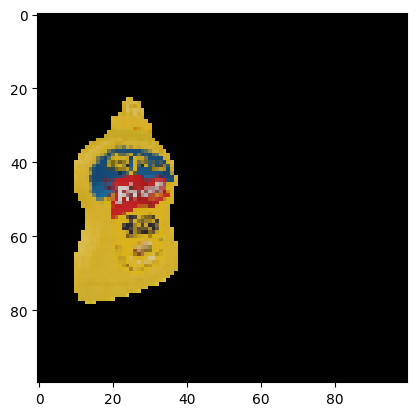

In [11]:
plt.imshow(images[0])

In [12]:
images[4].shape

(100, 100, 3)

In [13]:
## drawing a triangle of triangles in the scene

In [14]:
# mesh objects can be created from existing faces and vertex data
mesh = trimesh.Trimesh(vertices=[[0, 0, 0], [0, 0, 1], [0, 1, 0], [1, 1, 1], [1, 1, 2], [1, 2, 1]],
                       faces=[[0, 1, 2], [3, 4, 5]])

In [15]:
vertices = jnp.array(mesh.vertices) * 20.0
vertices = vertices - vertices.mean(0)
faces = jnp.array(mesh.faces)
#vertex_colors = jnp.array(mesh.visual.to_color().vertex_colors)[...,:3] / 255.0


rr.log(
    "/3d/mesh2",
    rr.Mesh3D(
        vertex_positions=mesh.vertices,
        indices=mesh.faces,
        vertex_colors=jnp.array([[255,0,0], [0,255,0], [255,0,0], [0,255,0], [255,0,0], [0,255,0]])
    ),
    timeless=True
)

In [16]:
# propose circle mask
# pick vertices on the mask
# make triangle based on texture
# generate movement proposals
# marginalize out over movement proposals to find the best features

In [17]:
indices = jnp.indices((height, width)).transpose(1,2,0)
# restrict to circles not within 3 of the edge
edge_buffer = triangle_boundary_radius = 5
indices = indices[edge_buffer:height-edge_buffer, edge_buffer:width-edge_buffer, :]
indices = indices.reshape(-1, 2)


In [18]:
key = jax.random.PRNGKey(15)
triangles = 500
choices = jax.random.choice(key, indices, shape=(triangles,))

In [19]:
# r = jax.random.uniform(key, shape=(triangles*2,)) * triangle_radius
# theta = jax.random.uniform(key, shape=(triangles*2,)) * 2 * jnp.pi

r = triangle_boundary_radius
theta_1 = jax.random.uniform(key, shape=(triangles,)) * 2 * jnp.pi / 3 
theta_2 = theta_1 + 2 * jnp.pi / 3 
theta_3 = theta_1 + 4 * jnp.pi / 3


In [20]:
vertex1 = jnp.round(choices + jnp.array([jnp.multiply(r,jnp.cos(theta_1)), jnp.multiply(r,jnp.sin(theta_1))]).T).astype(int)
vertex2 = jnp.round(choices + jnp.array([jnp.multiply(r,jnp.cos(theta_2)), jnp.multiply(r,jnp.sin(theta_2))]).T).astype(int)
vertex3 = jnp.round(choices + jnp.array([jnp.multiply(r,jnp.cos(theta_3)), jnp.multiply(r,jnp.sin(theta_3))]).T).astype(int)

In [21]:
vertices = jnp.array([vertex1, vertex2, vertex3]).transpose(1,0,2)

In [22]:
vertices.shape

(500, 3, 2)

In [23]:
vertices_flattened = vertices.reshape(-1,2)

In [24]:
# unproject point cloud and index the depth image

In [25]:
intrinsics = (width, height, fx, fy, cx, cy, near, far)
pc = unproject_depth(depths[4], intrinsics)

In [26]:
triangle_vertices = pc[tuple(vertices_flattened.T)]

In [27]:
triangle_indices = jnp.arange(0,300).reshape(100,3)

In [28]:
mesh = trimesh.Trimesh(vertices=triangle_vertices, faces=triangle_indices)

In [29]:
rr.log(
    "/3d/mesh3",
    rr.Mesh3D(
        vertex_positions=triangle_vertices,
        indices=triangle_indices,
        #vertex_colors=jnp.array([[255,0,0], [0,255,0], [255,0,0], [0,255,0], [255,0,0], [0,255,0]])
    ),
    timeless=True
)

In [30]:
rr.log(
    '/log_cloud',
    rr.Points3D(pc.reshape(-1,3)),
    timeless=True
)

In [31]:
 #rr.log('/pinhole', rr.Pinhole(camera_xyz=…))
rr.log("world", rr.ViewCoordinates.RIGHT_HAND_Z_UP, timeless=True)
rr.log(
    "world/xyz",
    rr.Arrows3D(
        vectors=[[1, 0, 0], [0, 1, 0], [0, 0, 1]],
        colors=[[255, 0, 0], [0, 255, 0], [0, 0, 255]],
    ),
)

In [32]:
# rr.log(
#     "world/xyz",
#     rr.Arrows3D(
#         vectors=pose.inv().as_matrix()[0:3,0:3],
#         colors=[[255, 0, 0], [0, 255, 0], [0, 0, 255]],
#     ),
# )

In [33]:
pose.as_matrix()[0:3,0:3]

Array([[-3.1622779e-01,  9.4868326e-01, -8.9406967e-08],
       [ 8.9406967e-08, -4.4703484e-08, -1.0000000e+00],
       [-9.4868326e-01, -3.1622779e-01, -2.9802322e-08]], dtype=float32)

In [34]:
# subtriangles
# recursively turn each triangle into four triangle 



In [35]:
triangle_vertices = jnp.array([triangle_vertices])
triangle_indices = jnp.array([triangle_indices])

In [36]:
len(triangle_vertices[0])

1500

In [37]:
vertices_flattened.shape

(1500, 2)

In [38]:
#jax routine to interpolate

#given a list of 4 vertex meshes, returns subdivided high-resolution mesh
 
def subdivide_triangles(triangle_vertices_list, triangle_indices_list, triangle_vertex_projections):
    # input triangle 
    num_triangle_vertices = len(triangle_vertices_list)
    num_triangles = len(triangle_indices_list)
    triangle_vertices_out = jnp.zeros((num_triangle_vertices*2, 3))
    triangle_vertex_projections_out = jnp.zeros((num_triangle_vertices*2, 2))
    
    triangle_vertices_out = triangle_vertices_out.at[0:num_triangle_vertices].set(triangle_vertices_list)
    triangle_indices_list_out = jnp.zeros((num_triangles*4, 3))
    triangle_vertex_projections_out = triangle_vertex_projections_out.at[0:num_triangle_vertices].set(triangle_vertex_projections)

    for ind, triangle_indices in enumerate(triangle_indices_list):
        p1, p2, p3 = triangle_vertices_list[triangle_indices]
        m1, m2, m3 = (p1 + p2)/2, (p2 + p3)/2, (p3 + p1)/2
        p1_pix, p2_pix, p3_pix = triangle_vertex_projections[triangle_indices]
        m1_pix, m2_pix, m3_pix = (p1_pix + p2_pix)/2, (p2_pix + p3_pix)/2, (p3_pix + p1_pix)/2
        
        triangle_vertices_out = triangle_vertices_out.at[num_triangle_vertices + 3*ind:num_triangle_vertices + 3*(ind+1)].set(jnp.array([m1, m2, m3]))
        triangle_vertex_projections_out = triangle_vertex_projections_out.at[num_triangle_vertices + 3*ind:num_triangle_vertices + 3*(ind+1)].set(jnp.array([m1_pix, m2_pix, m3_pix]))
        triangle_indices_list_out = triangle_indices_list_out.at[ind].set(np.array([num_triangle_vertices + 3*ind, num_triangle_vertices + 3*ind + 1, num_triangle_vertices + 3*ind + 2]))
        triangle_indices_list_out = triangle_indices_list_out.at[num_triangles + ind].set(np.array([triangle_indices[0], num_triangle_vertices + 3*ind, num_triangle_vertices + 3*ind + 2]))
        triangle_indices_list_out = triangle_indices_list_out.at[2*num_triangles + ind].set(np.array([triangle_indices[1], num_triangle_vertices + 3*ind, num_triangle_vertices + 3*ind + 1]))
        triangle_indices_list_out = triangle_indices_list_out.at[3*num_triangles + ind].set(np.array([triangle_indices[2], num_triangle_vertices + 3*ind + 1, num_triangle_vertices + 3*ind + 2]))

    return triangle_vertices_out, triangle_indices_list_out.astype(int), jnp.round(triangle_vertex_projections_out).astype(int)
        

# todo: grab color value from nearest point

# make these individual

In [39]:
sub_v, sub_i, sub_vf = subdivide_triangles(triangle_vertices[0], triangle_indices[0], vertices_flattened)


In [40]:
rr.log(
    "/3d/mesh4",
    rr.Mesh3D(
        vertex_positions=sub_v,
        indices=sub_i[0:100],
        #vertex_colors=jnp.array([[255,0,0], [0,255,0], [255,0,0], [0,255,0], [255,0,0], [0,255,0]])
    ),
    timeless=True
)

In [41]:
images[4][*sub_vf.T].shape

(3000, 3)

In [42]:
colors = jnp.round(images[4][*sub_vf.T]*255).astype(int)

In [43]:
rr.log(
    "/3d/mesh5",
    rr.Mesh3D(
        vertex_positions=sub_v,
        indices=sub_i,
        vertex_colors=colors
    ),
    timeless=True
)

In [44]:
sub_v.shape

(3000, 3)

In [45]:
sub_vf.shape

(3000, 2)

In [46]:
colors

Array([[0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       ...,
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0]], dtype=int32)

In [47]:
Pose.identity().as_matrix()[None,...].shape

(1, 4, 4)

In [48]:
ranges = jnp.array([[0, len(sub_i)]])
im_mesh, depth_mesh = renderer.render_attribute(Pose.identity().as_matrix()[None,...], sub_v, sub_i, ranges, colors/255.0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


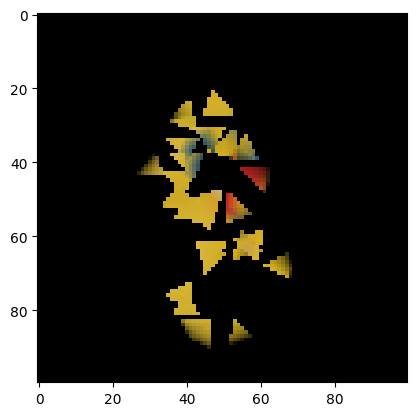

In [49]:
plt.imshow(im_mesh)

In [50]:
sub_i

Array([[1500, 1501, 1502],
       [1503, 1504, 1505],
       [1506, 1507, 1508],
       ...,
       [ 293, 1792, 1793],
       [ 296, 1795, 1796],
       [ 299, 1798, 1799]], dtype=int32)

In [51]:
len(sub_i)

400

In [52]:
sub_i[:,:,]

Array([[1500, 1501, 1502],
       [1503, 1504, 1505],
       [1506, 1507, 1508],
       ...,
       [ 293, 1792, 1793],
       [ 296, 1795, 1796],
       [ 299, 1798, 1799]], dtype=int32)

In [53]:
v_pc = voxelize(pc.reshape(-1,3), 0.1)

In [54]:
voxelized_mesh = make_voxel_mesh_from_point_cloud(v_pc, 0.1)

In [55]:
rr.log(
    "/3d/mesh6",
    rr.Mesh3D(
        vertex_positions=voxelized_mesh.vertices,
        indices=voxelized_mesh.faces,
        #vertex_colors=colors
    ),
    timeless=True
)

In [56]:
voxelized_mesh.faces

TrackedArray([[    1,     3,     0],
              [    4,     1,     0],
              [    0,     3,     2],
              ...,
              [73634, 73639, 73638],
              [73638, 73637, 73636],
              [73639, 73637, 73638]])

In [57]:
jnp.sqrt(len(v_pc))

Array(95.942696, dtype=float32, weak_type=True)

In [58]:
# determine if point is inside triangle
def sign(p1, p2, p3):
    return (p1[0] - p3[0]) * (p2[1] - p3[1]) - (p2[0] - p3[0]) * (p1[1] - p3[1])

def point_in_triangle(pt, v1, v2, v3):
    d1 = sign(pt, v1, v2)
    d2 = sign(pt, v2, v3)
    d3 = sign(pt, v3, v1)

    has_neg = (d1 < 0) | (d2 < 0) | (d3 < 0)
    has_pos = (d1 > 0) | (d2 > 0) | (d3 > 0)

    return jnp.logical_not(jnp.array((has_neg & has_pos)))

point_in_triangles_vec = jax.vmap(point_in_triangle, in_axes=(None, 0, 0, 0))
points_in_triangles_vec = jax.vmap(point_in_triangles_vec, in_axes=(0, None, None, None))

In [59]:
indices = jnp.indices((height, width)).transpose(1,2,0).reshape(-1,2)
ptv = points_in_triangles_vec(indices, vertex1, vertex2, vertex3)

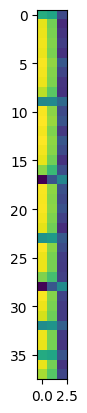

In [60]:
plt.imshow(images[4][ptv[:,12].reshape(100,100)])

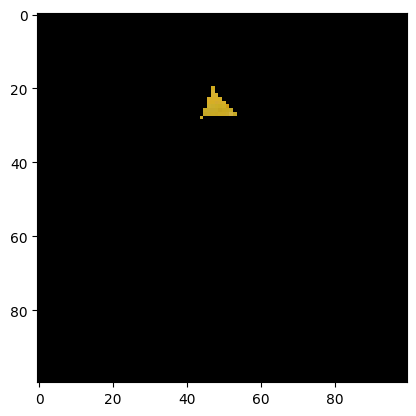

In [61]:
plt.imshow(np.multiply(images[4],ptv[:,10].reshape(100,100)[:,:,None]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


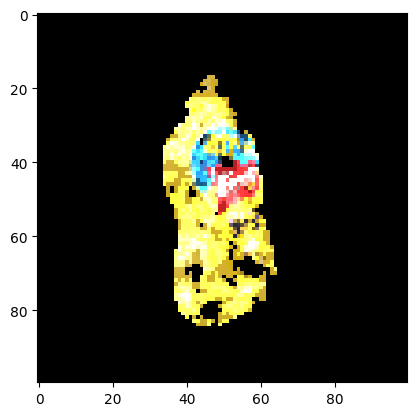

In [62]:
plt.imshow(np.multiply(images[4],jnp.sum(ptv, axis=1).reshape(100,100)[:,:,None]))

In [63]:
test_triangle = ptv[:,12].reshape(100,100)

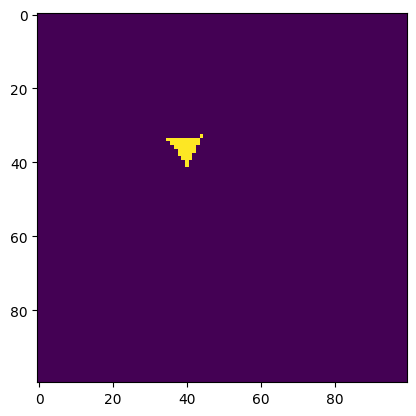

In [64]:
plt.imshow(test_triangle)

In [65]:
v_feat = voxelize(pc[test_triangle], 0.001)
m_feat = make_voxel_mesh_from_point_cloud(v_feat, 0.001)

In [66]:
m_feat

<trimesh.Trimesh(vertices.shape=(304, 3), faces.shape=(456, 3))>

In [67]:
im_feat, depth_feat = renderer.render_attribute(Pose.identity().as_matrix()[None,...], m_feat.vertices, m_feat.faces, ranges = jnp.array([[0, len(m_feat.faces)]]),
                                                 attributes=colors/255.0)

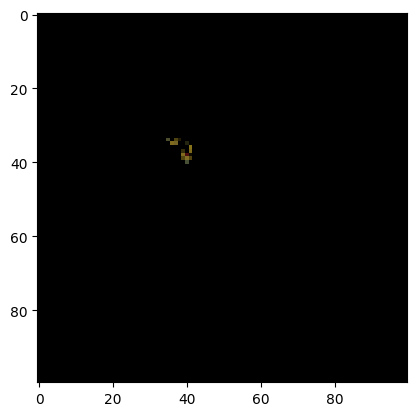

In [68]:
plt.imshow(im_feat)

In [69]:
# voxelize the features into clouds 

In [70]:
test_mesh = trimesh.Trimesh(m_feat.vertices, m_feat.faces)

In [71]:
from b3d.utils import make_mesh_from_point_cloud_and_resolution

In [72]:
images[4][test_triangle]

Array([[0.56117225, 0.53203773, 0.2507158 ],
       [0.8237617 , 0.6899372 , 0.17592633],
       [0.830988  , 0.697527  , 0.1984636 ],
       [0.8384028 , 0.7074575 , 0.22416463],
       [0.83217764, 0.69905275, 0.19322425],
       [0.8471503 , 0.7254444 , 0.29415095],
       [0.8412826 , 0.70940566, 0.24216045],
       [0.8316873 , 0.6997064 , 0.20028567],
       [0.7721838 , 0.65715927, 0.19320877],
       [0.44097257, 0.45021498, 0.34310693],
       [0.84584504, 0.7190102 , 0.25400704],
       [0.853521  , 0.73277754, 0.2820614 ],
       [0.8407154 , 0.70383924, 0.20735666],
       [0.85137904, 0.7216446 , 0.28618467],
       [0.84077895, 0.71388096, 0.253542  ],
       [0.8246818 , 0.6871467 , 0.19212905],
       [0.7164664 , 0.60556656, 0.26508737],
       [0.08029404, 0.2807907 , 0.4333272 ],
       [0.8468872 , 0.7220164 , 0.27152732],
       [0.84206   , 0.7131    , 0.24792168],
       [0.84511656, 0.7199695 , 0.2761747 ],
       [0.8371234 , 0.7041664 , 0.22831365],
       [0.

In [73]:
pc[test_triangle]

Array([[-0.30331534, -0.85939354,  2.527628  ],
       [-0.81222063, -0.8663687 ,  2.7074022 ],
       [-0.72187877, -0.8250043 ,  2.5781384 ],
       [-0.6526564 , -0.8032694 ,  2.510217  ],
       [-0.59224486, -0.7896598 ,  2.467687  ],
       [-0.53997475, -0.7854178 ,  2.4544306 ],
       [-0.4906799 , -0.7850879 ,  2.4533997 ],
       [-0.44340536, -0.7882762 ,  2.4633632 ],
       [-0.39676964, -0.7935393 ,  2.4798102 ],
       [-0.3502163 , -0.8004944 ,  2.501545  ],
       [-0.71106535, -0.76185566,  2.539519  ],
       [-0.644971  , -0.7441973 ,  2.4806578 ],
       [-0.588506  , -0.7356325 ,  2.4521084 ],
       [-0.5374989 , -0.73295295,  2.4431767 ],
       [-0.4892349 , -0.7338523 ,  2.4461746 ],
       [-0.44262838, -0.73771393,  2.4590466 ],
       [-0.39626175, -0.74299073,  2.476636  ],
       [-0.34961775, -0.74918085,  2.4972696 ],
       [-0.6406589 , -0.68994045,  2.464073  ],
       [-0.5858113 , -0.6834465 ,  2.4408805 ],
       [-0.53572655, -0.68183374,  2.435

In [74]:
v, f, vc, fc = make_mesh_from_point_cloud_and_resolution(pc[test_triangle], images[4][test_triangle], pc[test_triangle][:,2] / fx * 4.0)

In [75]:
im_feat, depth_feat = renderer.render_attribute(Pose.identity().as_matrix()[None,...], v, f, ranges = jnp.array([[0, len(f)]]),
                                                 attributes=vc)

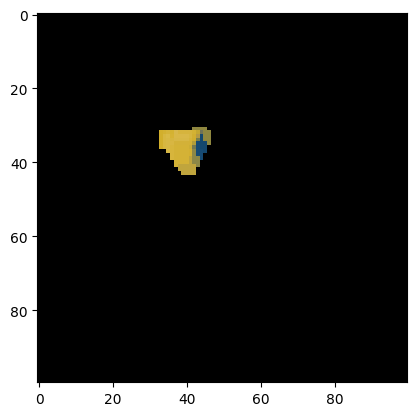

In [76]:
plt.imshow(im_feat)

In [77]:
rr.log(
    "/3d/mesh6",
    rr.Mesh3D(
        vertex_positions=v,
        indices=f,
        vertex_colors=vc
    ),
    timeless=True
)

In [78]:
# take mesh, generate motion proposal, and score in parallel

In [79]:
object_library = b3d.MeshLibrary.make_empty_library()

In [80]:
object_library.add_object(v, f, vc)

In [81]:
object_library.faces

Array([[  1,   3,   0],
       [  4,   1,   0],
       [  0,   3,   2],
       ...,
       [298, 303, 302],
       [302, 301, 300],
       [303, 301, 302]], dtype=int32)

In [82]:
for i in range(ptv.shape[1]):
    test_triangle = ptv[:,i].reshape(100,100)
    v, f, vc, fc = make_mesh_from_point_cloud_and_resolution(pc[test_triangle], images[4][test_triangle], pc[test_triangle][:,2] / fx * 4.0)
    object_library.add_object(v, f, vc)

In [83]:
object_library.faces.shape

(220416, 3)

In [84]:
f.shape

(444, 3)

In [85]:
model = b3d.model_multiobject_gl_factory(renderer)

In [ ]:
trace, _ = model.importance(
    jax.random.PRNGKey(0),
    genjax.choice_map(
        dict([
            ("camera_pose", Pose.identity()),
            *[(f"object_pose_{i}", all_poses[i]) for i in range(num_objects)],
            *[(f"object_{i}", i) for i in range(num_objects)],
            ("observed_rgb", rgbs_resized[START_T]),
            ("observed_depth", xyzs[START_T,...,2]),
        ])
    ),
    arguments
)

In [87]:
object_library.attributes.shape

(146944, 3)

In [88]:
object_library.ranges

Array([[     0,    456],
       [   456,    444],
       [   900,    444],
       ...,
       [219108,    408],
       [219516,    456],
       [219972,    444]], dtype=int32)

In [89]:
object_library.ranges[0]

Array([  0, 456], dtype=int32)

In [92]:
object_library.vertices.shape

(146944, 3)

In [99]:
library_obj_indices_to_render = jnp.empty((0,), dtype=int)
object_identity=11
library_obj_indices_to_render = jnp.concatenate((library_obj_indices_to_render, jnp.array([object_identity])))


In [100]:
library_obj_indices_to_render

Array([11], dtype=int32)

In [101]:
object_library.vertices, object_library.faces, object_library.ranges[library_obj_indices_to_render] * (library_obj_indices_to_render >= 0).reshape(-1,1), object_library.attributes

(Array([[-0.40442047, -0.96049863,  2.4265227 ],
        [-0.40442047, -0.96049863,  2.6287332 ],
        [-0.40442047, -0.75828844,  2.4265227 ],
        ...,
        [-5.7599998 ,  7.36      , 16.64      ],
        [-5.7599998 ,  8.64      , 15.36      ],
        [-5.7599998 ,  8.64      , 16.64      ]], dtype=float32),
 Array([[     1,      3,      0],
        [     4,      1,      0],
        [     0,      3,      2],
        ...,
        [146938, 146943, 146942],
        [146942, 146941, 146940],
        [146943, 146941, 146942]], dtype=int32),
 Array([[4800,  444]], dtype=int32),
 Array([[0.56117225, 0.53203773, 0.2507158 ],
        [0.56117225, 0.53203773, 0.2507158 ],
        [0.56117225, 0.53203773, 0.2507158 ],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]], dtype=float32))

In [102]:
im_feat, depth_feat = renderer.render_attribute(Pose.identity().as_matrix()[None,...], object_library.vertices, object_library.faces, object_library.ranges[library_obj_indices_to_render] * (library_obj_indices_to_render >= 0).reshape(-1,1), object_library.attributes)

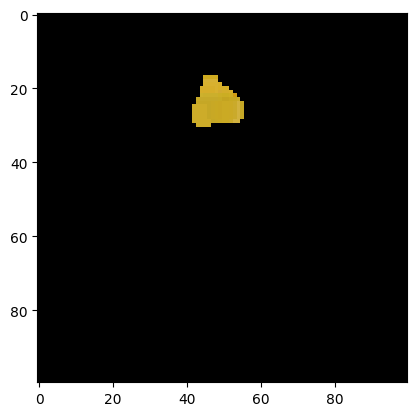

In [103]:
plt.imshow(im_feat)

In [104]:
library_obj_indices_to_render

Array([11], dtype=int32)